# IDENTIFYING RISKY BANK LOANS USING DECISION TREES


Rosa Karina Torres Calderon

In [2]:
import graphviz
import pydotplus
import pandas as pd
import numpy as np 
import io
#import rpy2.robjects as robjects
from sklearn import metrics
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.externals.six import StringIO 
from sklearn.ensemble import AdaBoostClassifier

Functions

In [3]:
def percentClasses(series, label1,label2):
    percent = series.value_counts(); #Get percentage of the classes
    percent = percent.values.tolist()
    clase1 = (percent[0]*100)/(percent[0]+percent[1])
    clase2 = (percent[1]*100)/(percent[0]+percent[1])
    print("\nPorcentaje de " + label1 + ': ' + str(clase1) + '%')
    print("Porcentaje de " + label2 + ': ' + str(clase2) + '%')


In [4]:
def categoricalToNumerical(posColumn, dataframe):
    enc = LabelEncoder()
    label_encoder = enc.fit(dataframe.iloc[:, posColumn])
    print("Clases categoricas: ", label_encoder.classes_)
    t = label_encoder.transform(dataframe.iloc[:, posColumn])
    dataframe.iloc[:, posColumn] = t
    return dataframe

In [5]:
def measure_performance(X,y,clf, show_accuracy=True,
show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Reporte de clasificación")
        print(metrics.classification_report(y,y_pred),"\n")
    if show_confusion_matrix:
        print('Matriz de confusión')
        print('')
        print(pd.crosstab(y, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

In [6]:
from sklearn.tree import _tree
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

# Step 1- Reading the data set

In [7]:
credit = pd.read_csv("credit.csv")
print(credit.head(5))
print(" ")
print('Tamaño del data set: ' + str(credit.shape))

  checking_balance  months_loan_duration credit_history    purpose  amount  \
0           < 0 DM                     6       critical   radio/tv    1169   
1       1 - 200 DM                    48         repaid   radio/tv    5951   
2          unknown                    12       critical  education    2096   
3           < 0 DM                    42         repaid  furniture    7882   
4           < 0 DM                    24        delayed  car (new)    4870   

  savings_balance employment_length  installment_rate personal_status  \
0         unknown           > 7 yrs                 4     single male   
1        < 100 DM         1 - 4 yrs                 2          female   
2        < 100 DM         4 - 7 yrs                 2     single male   
3        < 100 DM         4 - 7 yrs                 2     single male   
4        < 100 DM         1 - 4 yrs                 3     single male   

  other_debtors  ...                  property age  installment_plan  \
0          none  ...

# Step 2- Exploring and preparing the data

In [9]:
print(credit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_balance        1000 non-null int64
months_loan_duration    1000 non-null int64
credit_history          1000 non-null int64
purpose                 1000 non-null int64
amount                  1000 non-null int64
savings_balance         1000 non-null int64
employment_length       1000 non-null int64
installment_rate        1000 non-null int64
personal_status         1000 non-null int64
other_debtors           1000 non-null int64
residence_history       1000 non-null int64
property                1000 non-null int64
age                     1000 non-null int64
installment_plan        1000 non-null int64
housing                 1000 non-null int64
existing_credits        1000 non-null int64
default                 1000 non-null int64
dependents              1000 non-null int64
telephone               1000 non-null int64
foreign_worker          1000 non-null int64
job           

In [10]:
# Take a look at some features of loans that seem likely to predict a default
print('Checking balance values :')
print(credit.checking_balance.unique())
print('Saving balance values :')
print(credit.savings_balance.unique())

Checking balance values :
[1 0 3 2]
Saving balance values :
[4 2 1 3 0]


In [11]:
# Scikit-learn Decision Tree algorithm does not support categorical variables for now.
# Transform features with categorical data to numerical data 
credit = categoricalToNumerical(0, credit)  #checking balance
credit = categoricalToNumerical(2, credit)  #credit history
credit = categoricalToNumerical(3, credit)  #purpose
credit = categoricalToNumerical(5, credit)  #savings_balance
credit = categoricalToNumerical(6, credit)  #employment_length
credit = categoricalToNumerical(8, credit)  #personal status
credit = categoricalToNumerical(9, credit)  #other_debtors
credit = categoricalToNumerical(11, credit) #property
credit = categoricalToNumerical(13, credit) #installment_plan
credit = categoricalToNumerical(14, credit) #housing
credit = categoricalToNumerical(18, credit)  #telephone
credit = categoricalToNumerical(19, credit) #foreign_worker
credit = categoricalToNumerical(20, credit) #job
print(credit.head(5))

Clases categoricas:  [0 1 2 3]
Clases categoricas:  [0 1 2 3 4]
Clases categoricas:  [0 1 2 3 4 5 6 7 8 9]
Clases categoricas:  [0 1 2 3 4]
Clases categoricas:  [0 1 2 3 4]
Clases categoricas:  [0 1 2 3]
Clases categoricas:  [0 1 2]
Clases categoricas:  [0 1 2 3]
Clases categoricas:  [0 1 2]
Clases categoricas:  [0 1 2]
Clases categoricas:  [0 1]
Clases categoricas:  [0 1]
Clases categoricas:  [0 1 2 3]
   checking_balance  months_loan_duration  credit_history  purpose  amount  \
0                 1                     6               0        7    1169   
1                 0                    48               4        7    5951   
2                 3                    12               0        4    2096   
3                 1                    42               4        5    7882   
4                 1                    24               1        1    4870   

   savings_balance  employment_length  installment_rate  personal_status  \
0                4                  3           

In [12]:
# Visualize some statistical values of numerical features 
print(credit[['months_loan_duration','amount']].describe())
# The loans amount ranged from 250 DM to 18424 DM across terms of 4 to 72 months

       months_loan_duration        amount
count           1000.000000   1000.000000
mean              20.903000   3271.258000
std               12.058814   2822.736876
min                4.000000    250.000000
25%               12.000000   1365.500000
50%               18.000000   2319.500000
75%               24.000000   3972.250000
max               72.000000  18424.000000


In [13]:
# Convert default feature values 1-2  to Yes-No
credit["default"] = credit["default"].map({1: "No", 2:"Yes"})
credit["default"] = credit.default.astype("category")

In [14]:
# Visualize the default variable. It indicates us whether the loan applicant was unable to meet the agreed payment terms and went into default
print("Número de solicitantes que cumplieron y no cumplieron con los pagos: ")
print(credit["default"].value_counts()) 

credit_target = credit.loc[:,'default']
credit = credit.drop('default', axis=1)

# A high rate of default is undesirable for a bank because it means that the bank is unlikely to fully recover its investment.

Número de solicitantes que cumplieron y no cumplieron con los pagos: 
No     700
Yes    300
Name: default, dtype: int64


Data preparation - creating training and test datasets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(credit,credit_target,test_size=0.10,random_state=42)  #split dataset in 90% train 10% test

In [18]:
# Visualize the percentage of data in the train and test sets of both classes (Yes and No)
print('Dataset de Entrenamiento')
percentClasses(y_train,'solicitantes que no cumplieron', 'solicitantes que cumplieron')
print('\nDataset de Prueba')
percentClasses(y_test,'solicitantes que no cumplieron', 'solicitantes que cumplieron')

Dataset de Entrenamiento

Porcentaje de solicitantes que no cumplieron: 69.88888888888889%
Porcentaje de solicitantes que cumplieron: 30.11111111111111%

Dataset de Prueba

Porcentaje de solicitantes que no cumplieron: 71.0%
Porcentaje de solicitantes que cumplieron: 29.0%


# Step 3- Training a Model on the data

In [19]:
# CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.
clf = DecisionTreeClassifier(criterion='entropy') #  optimised version of the CART-algorithm
clf = clf.fit(X_train,y_train)
print(clf)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


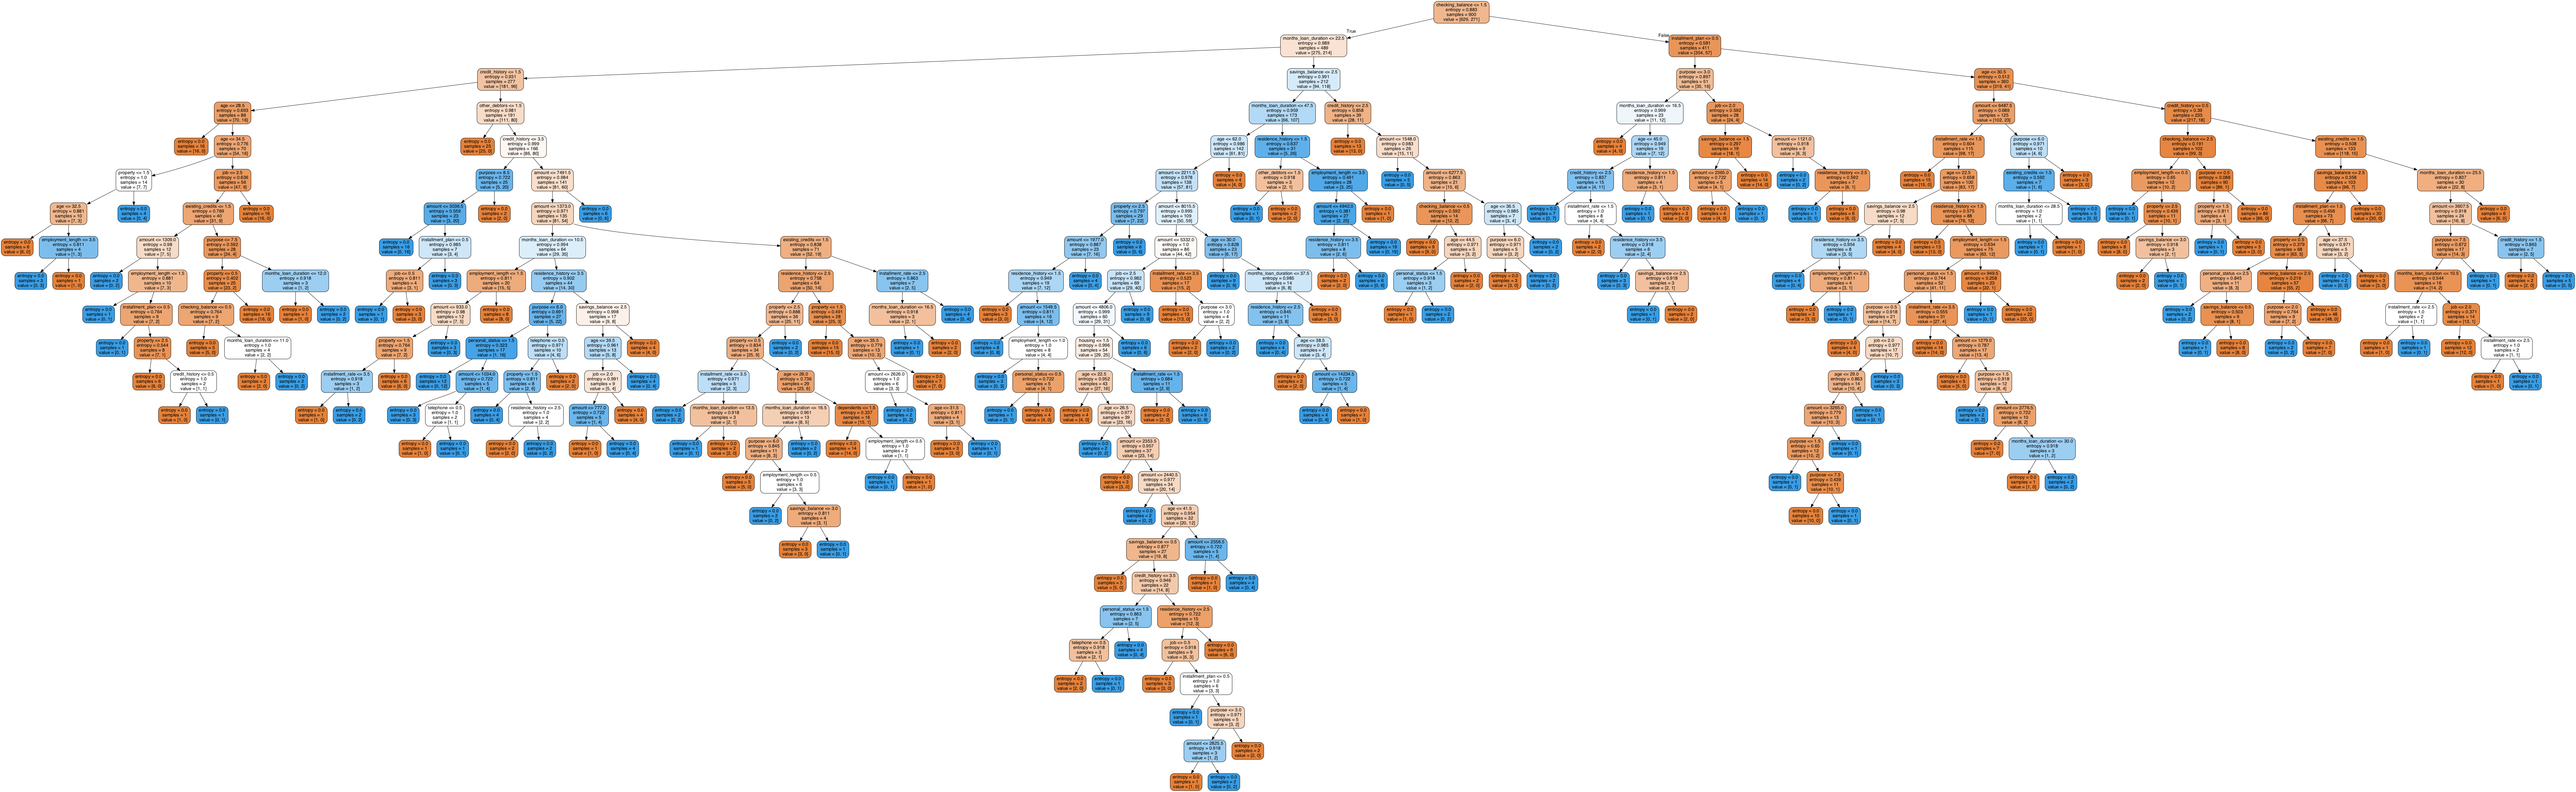

In [21]:
#Create DOT data
feature_names = list(credit.columns)
dot_data = io.StringIO()
export_graphviz(clf, out_file = dot_data, filled = True, rounded = True, feature_names = feature_names)
# Draw graph
graph = pydotplus.graphviz.graph_from_dot_data(dot_data.getvalue())
# Show graph
Image(graph.create_png())

In [22]:
# Save image in a  PNG
graph.write_png("credit.png")

True

In [23]:
treeObj = clf.tree_
print ("Número total de nodos en el árbol: " + str(treeObj.node_count))
#print ("Número de características utilizadas para dividir el árbol: " + str(treeObj.feature))

Número total de nodos en el árbol: 357


In [24]:
# Extracting the decision rules from de decision tree 
tree_to_code(clf, credit.columns)

def tree(checking_balance, months_loan_duration, credit_history, purpose, amount, savings_balance, employment_length, installment_rate, personal_status, other_debtors, residence_history, property, age, installment_plan, housing, existing_credits, dependents, telephone, foreign_worker, job):
  if checking_balance <= 1.5:
    if months_loan_duration <= 22.5:
      if credit_history <= 1.5:
        if age <= 28.5:
          return [[16.  0.]]
        else:  # if age > 28.5
          if age <= 34.5:
            if property <= 1.5:
              if age <= 32.5:
                return [[6. 0.]]
              else:  # if age > 32.5
                if employment_length <= 3.5:
                  return [[0. 3.]]
                else:  # if employment_length > 3.5
                  return [[1. 0.]]
            else:  # if property > 1.5
              return [[0. 4.]]
          else:  # if age > 34.5
            if job <= 2.5:
              if existing_credits <= 1.5:
                if amount <=

# Step 4- Evaluating model performance

In [26]:
# Evaluating the model in the test set 
measure_performance(X_test,y_test,clf,show_accuracy=True,show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.790 

Reporte de clasificación
              precision    recall  f1-score   support

          No       0.83      0.89      0.86        71
         Yes       0.67      0.55      0.60        29

   micro avg       0.79      0.79      0.79       100
   macro avg       0.75      0.72      0.73       100
weighted avg       0.78      0.79      0.78       100
 

Matriz de confusión

Predicted  No  Yes  All
True                   
No         63    8   71
Yes        13   16   29
All        76   24  100


# Step 5- Improving model performance

Applying adaptative boosting (many decision trees are built)

In [27]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.5)
clf.fit(X_train,y_train)  

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=100, random_state=None)

In [29]:
# Evaluating the model in the train set 
measure_performance(X_train,y_train,clf,show_accuracy=True,show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.812 

Reporte de clasificación
              precision    recall  f1-score   support

          No       0.84      0.91      0.87       629
         Yes       0.73      0.59      0.66       271

   micro avg       0.81      0.81      0.81       900
   macro avg       0.79      0.75      0.76       900
weighted avg       0.81      0.81      0.81       900
 

Matriz de confusión

Predicted   No  Yes  All
True                    
No         570   59  629
Yes        110  161  271
All        680  220  900


In [30]:
# Evaluating the model in the test set 
measure_performance(X_test,y_test,clf,show_accuracy=True,show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.800 

Reporte de clasificación
              precision    recall  f1-score   support

          No       0.85      0.87      0.86        71
         Yes       0.67      0.62      0.64        29

   micro avg       0.80      0.80      0.80       100
   macro avg       0.76      0.75      0.75       100
weighted avg       0.80      0.80      0.80       100
 

Matriz de confusión

Predicted  No  Yes  All
True                   
No         62    9   71
Yes        11   18   29
All        73   27  100
